<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MtrD-amino-acid-characterization" data-toc-modified-id="MtrD-amino-acid-characterization-1">MtrD amino acid characterization</a></span><ul class="toc-item"><li><span><a href="#BLAST" data-toc-modified-id="BLAST-1.1">BLAST</a></span></li><li><span><a href="#Alignment" data-toc-modified-id="Alignment-1.2">Alignment</a></span></li><li><span><a href="#Amino-acid-characterization" data-toc-modified-id="Amino-acid-characterization-1.3">Amino acid characterization</a></span></li><li><span><a href="#Association-with-MIC" data-toc-modified-id="Association-with-MIC-1.4">Association with MIC</a></span></li><li><span><a href="#MIC-distribution-plot" data-toc-modified-id="MIC-distribution-plot-1.5">MIC distribution plot</a></span></li><li><span><a href="#Other-resistance-genes" data-toc-modified-id="Other-resistance-genes-1.6">Other resistance genes</a></span></li><li><span><a href="#iTOL-tree" data-toc-modified-id="iTOL-tree-1.7">iTOL tree</a></span></li><li><span><a href="#SNP-distances-and-MIC-statistical-test" data-toc-modified-id="SNP-distances-and-MIC-statistical-test-1.8">SNP distances and MIC statistical test</a></span></li></ul></li></ul></div>

## MtrD amino acid characterization
We've included analysis code used to replicate the results and all figures for Ma and Mortimer et al., 2020 ("Efflux pump antibiotic binding site mutations are associated with azithromycin nonsusceptibility in clinical Neisseria gonorrhoeae isolates"). Please reach out with any questions to kevinchenma@g.harvard.edu and mortimer@hsph.harvard.edu we'll be happy to assist.

### BLAST

We use a published global meta-analysis collection of 4852 strains to conduct the genomic analyses (see https://github.com/gradlab/mtrC-GWAS for details). We use BLAST to pull out the mtrD sequences from the contigs using the FA1090 sequence as a reference. Then we apply several filters, including screening out mtrD sequences with lower than 99% nucleotide identity to focus our analyses on SNP mutations, and removing strains with predicted LOF mutations. The result is an amino acid alignment.

In [30]:
import pandas as pd
from Bio.Seq import Seq
import os

def blast_gene(gene):
    
    cmd = "blastn -db blast/2019-08-26_combined-contigs.fna -query blast/results/{0}-ref.fna -outfmt '6 sseqid length evalue pident sseq' -max_target_seqs 10000 -out blast/results/{0}-global.tsv".format(gene)
    metadata = pd.read_csv('metadata/2020-04-27_Supplementary-Table-6_Global-Strain-Collection.csv', sep=',')
    os.system(cmd)
    samples = []
    counter = 0

    for seq_record in SeqIO.parse('blast/results/{0}-ref.fna'.format(gene), "fasta"):
        fasta = seq_record.seq
        ntlen = len(fasta)
        aalen = len(fasta) / 3

    with open('blast/results/{0}-global.faa'.format(gene), 'w') as outfile, open('blast/results/{0}-global.tsv'.format(gene), 'r') as infile:
        for line in infile:
            name,length,evalue,pident,fasta = line.rstrip().split('\t')

            if name.split('|')[0] not in list(metadata['GWAS_ID']): # Limit to samples in spreadsheet
                continue
            
            if float(pident) < 99: # Filter out mosaic sequences
                continue
                
            if int(length) < ntlen-5 or int(length) > ntlen+5: # Filter for complete BLAST results
                continue

            if not fasta[0:3] in ['ATG', 'GTG', 'TTG']: # Screen out BLAST results without canonical start sites
                continue

            peptide = str(Seq(fasta).ungap('-').translate()).split('*')[0]
            if len(peptide) < 0.9*aalen: # Screen out LOF sequences
                continue
            
            outfile.write('>' + name.split('|')[0] + '\n')
            outfile.write(peptide + '\n')
            counter += 1

            if name in samples:
                print('Duplicate ' + name) # Possible gene duplication
    
    print('{0} samples remaining out of {1} samples.'.format(counter, len(list(metadata['GWAS_ID']))))

In [31]:
blast_gene('mtrD')

/home/kcm14/anaconda3/envs/pyseer/lib/python3.6/site-packages/Bio/Seq.py:2095: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


4209 samples remaining out of 4852 samples.


### Alignment
We use MAFFT to align the sequences.

In [32]:
!software/mafft-linux64/mafft.bat blast/results/mtrD-global.faa > mtrD/mtrD-global-aligned.faa

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
 4201 / 4209
done.

Constructing a UPGMA tree (efffree=0) ... 
 4200 / 4209
done.

Progressive alignment 1/2... 
STEP  4201 / 4208  h
done.

Making a distance matrix from msa.. 
 4200 / 4209
done.

Constructing a UPGMA tree (efffree=1) ... 
 4200 / 4209
done.

Progressive alignment 2/2... 
STEP  4201 / 4208  h
done.

disttbfast (aa) Version 7.450
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --l

### Amino acid characterization

In Lyu and Moseng et al., isogenic mtrD replacement experiments demonstrated that amino acids R714G and K823E increased resistance to macrolides, E669G increased susceptibility to macrolides, and R174Q, S821A, S825A, had no effect.

In [1]:
from Bio import AlignIO
from collections import Counter

alignment = AlignIO.read('mtrD/mtrD-global-aligned.faa', format='fasta')
aas = [174, 669, 714, 821, 823, 825]

for aa in aas:
    print(aa, Counter(alignment[:, aa-1]))

174 Counter({'R': 4209})
669 Counter({'E': 4209})
714 Counter({'R': 4197, 'H': 9, 'L': 2, 'C': 1})
821 Counter({'S': 4209})
823 Counter({'K': 4202, 'E': 6, 'N': 1})
825 Counter({'S': 4209})


We see amino acid diversity at sites 714 and 823 predicted to result in increased macrolide resistance and complete conservation at the other sites. Interestingly, while K823E is the major change at site 823, R714H is the major change at site 714 and there are no R714G strains.

### Association with MIC

We check to see if these clinical isolates indeed have higher azithromycin MICs as suggested. First, we pre-process the MICs to remove non-continuous values and correct for known errors due to media formulation changes in the GISP dataset (see https://www.biorxiv.org/content/10.1101/2020.01.07.896696v2 for details).

In [94]:
import pandas as pd
import numpy as np

metadata_filtered = pd.read_csv('metadata/2020-04-27_Supplementary-Table-6_Global-Strain-Collection.csv')
metadata_filtered = metadata_filtered.replace('SUS', np.nan)
metadata_filtered = metadata_filtered.replace('RES', np.nan)

metadata_filtered['AZI_LOG'] = metadata_filtered['Azithromycin'].map(lambda x: float(str(x).lstrip('><=')))

adjusted_MIC = []
for index, row in metadata_filtered.iterrows():
    if not row['Reference'].startswith('Grad'):
        adjusted_MIC.append(row['AZI_LOG'])
    else:
        if int(row['Year']) < 2005:
            adjusted_MIC.append(2*row['AZI_LOG'])
        else:
            adjusted_MIC.append(row['AZI_LOG'])
            
metadata_filtered['Azithromycin'] = adjusted_MIC
metadata_filtered['AZI_LOG'] = np.log2(metadata_filtered['Azithromycin'])

metadata_filtered['CRO_LOG'] = np.log2(metadata_filtered['Ceftriaxone'].map(lambda x: float(str(x).lstrip('><='))))
metadata_filtered['CIP_LOG'] = np.log2(metadata_filtered['Ciprofloxacin'].map(lambda x: float(str(x).lstrip('><='))))

metadata_filtered.to_csv('metadata/strain-table-filtered.csv', index=False)

In [2]:
import numpy as np

samples = []
for aln in alignment:
    samples.append(aln.id)
samples = np.array(samples)
    
samples_714 = list(samples[[x != 'R' for x in list(alignment[:, 714-1])]])
samples_823 = list(samples[[x != 'K' for x in list(alignment[:, 823-1])]])

Here are the strains with MtrD 714 mutations and corresponding MICs:

In [3]:
import pandas as pd

metadata = pd.read_csv('metadata/strain-table-filtered.csv', sep=',')
metadata[metadata['GWAS_ID'].isin(samples_714)][['GWAS_ID', 'Azithromycin']]

,GWAS_ID,Azithromycin
61,SRR1661243,1.00
185,SRR2736167,2.00
191,SRR2736175,2.00
285,SRR2736280,2.00
1171,GCGS1039,4.00
1409,GCGS1040,4.00
1512,GCGS0847,0.50
1862,ERR1469709,1.00
1867,ERR1469714,1.00
1959,ERR1514686,NaN


Here are the strains with MtrD 823 mutations and corresponding MICs:

In [4]:
metadata[metadata['GWAS_ID'].isin(samples_823)][['GWAS_ID', 'Azithromycin']]

,GWAS_ID,Azithromycin
153,SRR2736124,2.00
220,SRR2736213,2.00
286,SRR2736281,2.00
731,GCGS0502,2.00
1412,GCGS0330,2.00
1670,GCGS0759,8.00
4348,ERR363653,0.75


### MIC distribution plot
MtrD substitution strains do appear to be associated with higher MICs relative to non-MtrD substitution strains.

In [5]:
import numpy as np
from Bio import SeqIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

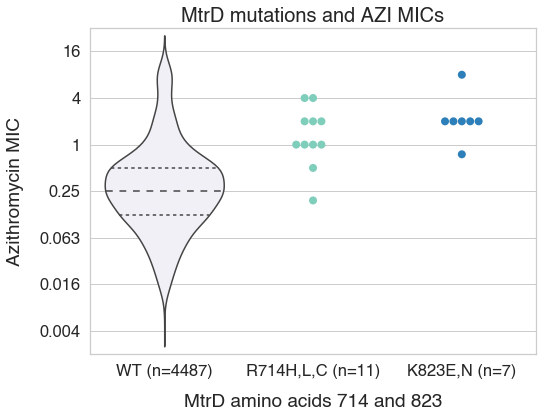

In [6]:
metadata = pd.read_csv('metadata/strain-table-filtered.csv', sep=',')
label714 = 'R714H,L,C (n=11)'
label823 = 'K823E,N (n=7)'
labelwt = 'WT (n=4487)'

mtrD_map = {}
for k in samples_714:
    mtrD_map[k] = label714
for k in samples_823:
    mtrD_map[k] = label823
categories = [mtrD_map[x] if x in mtrD_map else labelwt for x in metadata['GWAS_ID']]
metadata['MtrD_plot'] = categories

sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,6))

pal = {labelwt: '#f1f0f7', label714: '#7fcdbb', label823: '#2c7fb8'}

metadata_violin = metadata[metadata['MtrD_plot'] == labelwt]
ax = sns.violinplot(data=metadata_violin[metadata_violin['AZI_LOG'] <= 3], inner='quartile', saturation=0.9, cut=3, bw=.3, scale='area', x='MtrD_plot', y='AZI_LOG', order = [labelwt, label714, label823], palette = pal, jitter=True)

metadata_swarm = metadata[metadata['MtrD_plot'] != labelwt]
ax = sns.swarmplot(data=metadata_swarm[metadata_swarm['AZI_LOG'] <= 3], size=8, x='MtrD_plot', y='AZI_LOG', order = [labelwt, label714, label823], palette = pal)

ax.set_yticklabels(['',0.004,0.016,0.063,0.25,1,4,16])
plt.ylim(-9,5)
ax.set_xlabel("",fontsize=20)
ax.set_ylabel("",fontsize=18)
plt.ylabel('Azithromycin MIC',  fontsize=19, labelpad=15)
plt.xlabel('MtrD amino acids 714 and 823', fontsize=19, labelpad=15)
plt.title('MtrD mutations and AZI MICs', fontsize=20)
sns.set_style({'font.sans-serif': 'helvetica'})

plt.savefig('mtrD/2020-06-01_violin-plot.png', dpi=600)


### Other resistance genes

We check what other resistance genes are present in the MtrD strains that could also have contributed to increased MICs: almost all have the mtrR promoter mutation, and none have any of the 23S rRNA mutations. Two also have rare non-canonical RplD G70 mutations. Some isolates also possess mosaic penA conferring ceftriaxone reduced susceptibility.

In [7]:
import pandas as pd
pd.set_option('display.max_columns', 50)

covariates = pd.read_csv('metadata/combined-covariates.csv')
covariates = covariates.merge(metadata[['GWAS_ID', 'MtrD_plot', 'Azithromycin', 'Accession']])
covariates[covariates['MtrD_plot'] != labelwt]

,GWAS_ID,Country,Reference,Year,PBP1_421,PBP2_501,PBP2_542,PBP2_551,PorB_120,PorB_121,MtrR_39,MtrR_45,GyrA_91,GyrA_95,ParC_86,ParC_87,ParC_91,RpsJ_57,FolP_229,RplD_70,mtr_promoter,mtrR,Mosaic_Mtr_BAPS,Mosaic_PenA_BAPS,rRNA23S_2059,rRNA23S_2611,MtrD_plot,Azithromycin,Accession
61,SRR1661243,Canada,Demczuk2015,2010.0,P,A,S,P,K,N,A,G,F,G,G,R,E,M,S,G,-,full_length,11,6,0,0,"R714H,L,C (n=11)",1.00,SRR1661243
153,SRR2736124,Canada,Demczuk2016,2000.0,P,A,G,L,K,D,A,G,S,D,G,S,E,M,S,G,-,full_length,11,17,0,0,"K823E,N (n=7)",2.00,SRR2736124
185,SRR2736167,Canada,Demczuk2016,2010.0,P,A,S,P,K,N,A,G,F,G,G,R,E,M,S,G,-,full_length,11,6,0,0,"R714H,L,C (n=11)",2.00,SRR2736167
191,SRR2736175,Canada,Demczuk2016,2010.0,P,A,S,P,K,N,A,G,F,G,G,R,E,M,S,G,-,full_length,11,6,0,0,"R714H,L,C (n=11)",2.00,SRR2736175
220,SRR2736213,Canada,Demczuk2016,2011.0,P,A,G,P,K,D,A,D,F,A,G,R,E,M,S,S,-,full_length,10,17,0,0,"K823E,N (n=7)",2.00,SRR2736213
285,SRR2736280,Canada,Demczuk2016,2014.0,P,NaN,NaN,NaN,K,N,A,G,F,G,G,R,E,M,S,G,-,full_length,11,1,0,0,"R714H,L,C (n=11)",2.00,SRR2736280
286,SRR2736281,Canada,Demczuk2016,2014.0,P,T,G,P,K,D,A,G,F,G,G,S,G,M,S,G,-,full_length,11,17,0,0,"K823E,N (n=7)",2.00,SRR2736281
731,GCGS0502,USA,Grad2014_2016,2000.0,P,A,G,L,K,D,A,G,S,D,G,S,E,M,S,G,-,full_length,11,17,0,0,"K823E,N (n=7)",2.00,ERR1067793
1171,GCGS1039,USA,Grad2014_2016,2008.0,P,A,G,L,K,D,A,G,S,D,G,S,E,M,S,G,-,full_length,11,17,0,0,"R714H,L,C (n=11)",4.00,ERR854880
1409,GCGS1040,USA,Grad2014_2016,2008.0,P,A,G,L,K,D,A,G,S,D,G,S,E,M,S,G,-,full_length,11,17,0,0,"R714H,L,C (n=11)",4.00,ERR855125


We clean up these results for output as the main table.

In [21]:
allele_order = []
sample_order = []

for snp in ['H', 'L', 'C']:
    strains = samples[[x == snp for x in list(alignment[:, 714-1])]]
    for s in strains:
        allele_order.append('R714' + snp)
        sample_order.append(s)

for snp in ['E', 'N']:
    strains = samples[[x == snp for x in list(alignment[:, 823-1])]]
    for s in strains:
        allele_order.append('K823' + snp)
        sample_order.append(s)
        
alleles = pd.DataFrame.from_dict({'GWAS_ID': sample_order, 'MtrD Allele': allele_order})
alleles = alleles.merge(covariates)

clusters = {'GWAS_ID': ['ERR1469709', 'ERR1469714', 'ERR1528327', 'ERR1514686', 'SRR2736175', 'SRR1661243', 'SRR2736167', 'GCGS1039', 'GCGS1040'],
            'Cluster': [1, 1, 2, 2, 3, 3, 3, 4, 4]}
alleles = alleles.merge(pd.DataFrame.from_dict(clusters), how='left')

alleles['23S rRNA'] = 'WT'
alleles['mtrR Promoter'] = alleles['mtr_promoter'].apply(lambda x: 'Adel' if x == '-' else 'WT')
alleles['RplD G70 Allele'] = alleles['RplD_70'].apply(lambda x: x if x != 'G' else 'WT')
alleles['PenA Allele'] = alleles['Mosaic_PenA_BAPS'].apply(lambda x: 'XXXIV' if x == 1 else 'Non-mosaic')
alleles = alleles.replace(np.nan, 'NA', regex=True)
alleles = alleles[['Accession', 'Reference', 'Azithromycin', 'MtrD Allele', 'Cluster', 'mtrR Promoter', 'RplD G70 Allele', '23S rRNA', 'PenA Allele']]

alleles.to_csv('mtrD/2020-06-02_table1.tsv', sep='\t', index=False)

alleles

,Accession,Reference,Azithromycin,MtrD Allele,Cluster,mtrR Promoter,RplD G70 Allele,23S rRNA,PenA Allele
0,ERR1469714,Harris2018,1,R714H,1,Adel,WT,WT,XXXIV
1,ERR1528327,Harris2018,1,R714H,2,Adel,WT,WT,XXXIV
2,ERR1514686,Harris2018,NA,R714H,2,Adel,WT,WT,XXXIV
3,ERR1469709,Harris2018,1,R714H,1,Adel,WT,WT,XXXIV
4,SRR1661243,Demczuk2015,1,R714H,3,Adel,WT,WT,Non-mosaic
5,SRR2736280,Demczuk2016,2,R714H,NA,Adel,WT,WT,XXXIV
6,SRR2736175,Demczuk2016,2,R714H,3,Adel,WT,WT,Non-mosaic
7,SRR2736167,Demczuk2016,2,R714H,3,Adel,WT,WT,Non-mosaic
8,ERR349976,SanchezBuso2018,0.19,R714H,NA,WT,WT,WT,Non-mosaic
9,ERR854880,Grad2014_2016,4,R714L,4,Adel,WT,WT,Non-mosaic


### iTOL tree

We generate iTOL tree annotation rings below to visualize the phylogenetic distribution of the MtrD variants. The recombination-corrected phylogeny was generated in our previous study (https://www.biorxiv.org/content/10.1101/2020.01.07.896696v2). A link to a user-searchable version of the tree with the annotation rings is here: https://itol.embl.de/tree/1281032416307421591107815.

In [23]:
grouped = ['GCGS1039', 'GCGS1040', 'ERR1528327', 'ERR1514686', 'ERR1469709', 'ERR1469714', 'SRR2736175', 'SRR1661243', 'SRR2736167']

header = '''DATASET_COLORSTRIP

SEPARATOR TAB
#SEPARATOR COMMA
#SEPARATOR SPACE
DATASET_LABEL	MtrD resistance
COLOR	#2C7FB8

BORDER_WIDTH	6
BORDER_COLOR	#333333
STRIP_WIDTH	120

LEGEND_TITLE	MtrD mutations
LEGEND_SHAPES	1	1
LEGEND_COLORS	#7FCDBB	#2C7FB8
LEGEND_LABELS	R714H,L,C	K823E,N

DATA
'''
        
with open('mtrD/itol-mtrD-binary-base.txt', 'w') as outfile:
    outfile.write(header)
    outfile.write('GCGS1000\t#ffffff\tNone\n')
    
header = '''DATASET_BINARY

SEPARATOR TAB
#SEPARATOR COMMA
#SEPARATOR SPACE
DATASET_LABEL	MtrD resistance
COLOR	#2C7FB8

BORDER_WIDTH	5
BORDER_COLOR	#333333
STRIP_WIDTH	100

LEGEND_TITLE	MtrD mutations
FIELD_SHAPES	5	5
FIELD_COLORS	#7FCDBB	#2C7FB8
FIELD_LABELS	R714H,L,C	K823E,N
MAXIMUM_SIZE	30

SYMBOL_SPACING	-50
MARGIN	-70
HEIGHT_FACTOR	90

DATA
'''

with open('mtrD/itol-mtrD-binary-singletons.txt', 'w') as outfile:
    outfile.write(header)
    for index, s in metadata.iterrows():
        #if s['MtrD_plot'] == labelwt:
        #    outfile.write(s['GWAS_ID'] + '\t#F1F0F7\tWT\n')
        if s['GWAS_ID'] in grouped:
            continue
        if s['MtrD_plot'] == label714:
            outfile.write(s['GWAS_ID'] + '\t1\t-1\n')
        if s['MtrD_plot'] == label823:
            outfile.write(s['GWAS_ID'] + '\t-1\t1\n')
            
header = '''DATASET_BINARY

SEPARATOR TAB
#SEPARATOR COMMA
#SEPARATOR SPACE
DATASET_LABEL	MtrD resistance
COLOR	#2C7FB8

BORDER_WIDTH	5
BORDER_COLOR	#333333
STRIP_WIDTH	100

LEGEND_TITLE	MtrD mutations 
FIELD_SHAPES	3
FIELD_COLORS	#7FCDBB
FIELD_LABELS	R714H,L,C
MAXIMUM_SIZE	30

SYMBOL_SPACING	0
MARGIN	-5
HEIGHT_FACTOR	110

DATA
'''

with open('mtrD/itol-mtrD-binary-clusters.txt', 'w') as outfile:
    outfile.write(header)
    for s in grouped[:-1:2]:
        outfile.write(s + '\t1\n')

In [69]:
# Alternative visualization approach

header = '''DATASET_SYMBOL

SEPARATOR TAB
#SEPARATOR COMMA
#SEPARATOR SPACE
DATASET_LABEL	MtrD resistance
COLOR	#2C7FB8

BORDER_WIDTH	5
BORDER_COLOR	#333333
STRIP_WIDTH	100

LEGEND_TITLE	MtrD mutations
LEGEND_SHAPES	4	4
LEGEND_COLORS	#7FCDBB	#2C7FB8
LEGEND_LABELS	R714H,L,C	K823E,N
MAXIMUM_SIZE	100

DATA
'''
        
with open('mtrD/itol-mtrD-shapes.txt', 'w') as outfile:
    outfile.write(header)
    for index, s in metadata.iterrows():
        #if s['MtrD_plot'] == labelwt:
        #    outfile.write(s['GWAS_ID'] + '\t#F1F0F7\tWT\n')
        if s['MtrD_plot'] == label714:
            outfile.write(s['GWAS_ID'] + '\t4\t50\t#7FCDBB\t1\t1\tR714H,L,C\n')
        if s['MtrD_plot'] == label823:
            outfile.write(s['GWAS_ID'] + '\t4\t50\t#2C7FB8\t1\t1\tK823E,N\n')

### SNP distances and MIC statistical test

We use snp-dists (https://github.com/tseemann/snp-dists) to calculate pairwise SNP distances. The output of this (subsetted to rows of just MtrD substitution strains) is available in distances/nonrecombinant_snp_distances.tsv. We use these distances to 1) identify genetically matched controls without MtrD substitutions for conducting AZI MIC statistical comparisons (using the get_closet_strain.py script) 2) quantifying genetic distance within identified MtrD substitution clusters.

After identifying closest strains, we conduct a paired Wilcoxon test to identify a statistically significant difference in MIC distributions.

In [24]:
!python scripts/get_closest_strain.py distances/nonrecombinant_snp_distances.tsv distances/mtrD_strains.txt metadata/strain-table-filtered.csv

In [25]:
%load_ext rpy2.ipython

In [29]:
%%R

library(tidyverse)

paired_samples <- read_tsv("distances/paired_by_distance.txt")
wilcox.test(log2(paired_samples$mtrD_azi_mic), log2(paired_samples$wt_azi_mic), paired = TRUE)

R[write to console]: Parsed with column specification:
cols(
  mtrD_strain = col_character(),
  mtrD_mutation = col_character(),
  mtrD_azi_mic = col_double(),
  wt_strain = col_character(),
  wt_azi_mic = col_double(),
  SNP_distance = col_double()
)




	Wilcoxon signed rank test with continuity correction

data:  log2(paired_samples$mtrD_azi_mic) and log2(paired_samples$wt_azi_mic)
V = 133, p-value = 0.0008153
alternative hypothesis: true location shift is not equal to 0

